# <center>Predicting Bots</center>

In [2]:
# load packages

# pulling tweet data
import requests
import json
import tweepy

# data wrangling
import csv
import pandas as pd
import numpy as np

# text processing 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, plot_confusion_matrix, balanced_accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier 
from imblearn.pipeline import Pipeline
from sklearn import preprocessing as pp 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold # Cross validation 

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read in dataset of userids
user_ids = pd.read_csv('twitter_human_bots_dataset.csv')

In [4]:
# view data
user_ids

,id,account_type
0,787405734442958848,bot
1,796216118331310080,human
2,875949740503859204,human
3,756119643622735875,human
4,464781334,human
...,...,...
37433,63963107,human
37434,1064042478,human
37435,1089732602,human
37436,815529979,human


In [5]:
## ***the following code was used to pull the tweet data. It is commented out for the sake of being able to reproduce results in a reasonable time (it takes about 10 hours to pull all the tweets due to the twitter api rate limit on requests)***

In [6]:
# # for every user id in the dataset, pull the last five tweets in the TL (exclude RTs) and append them to a dataframe
# data = pd.DataFrame()
# for id in user_ids.id:
#     try:
#         tl = api.user_timeline(id, count = 5, include_rts = False, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#         json_data = [r._json for r in tl]
#         df = pd.json_normalize(json_data)
#         data = data.append(df)
#     except tweepy.TweepError:
#         print("Failed to run the command on that user, Skipping...") # throw an exception and move on if account data can't be pulled (account deleted or private)
# data

In [7]:
# # save the tweet data in its own csv 
# data.to_csv('tweet_data.csv', index = False)

In [8]:
# read in csv of tweet data
tweet_data = pd.read_csv('tweet_data.csv', quoting = csv.QUOTE_ALL, lineterminator = '\n')

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
# view tweet data
tweet_data

,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,quoted_status.geo.type,quoted_status.geo.coordinates,quoted_status.coordinates.type,quoted_status.coordinates.coordinates,quoted_status.scopes.followers,withheld_in_countries,withheld_scope,withheld_copyright
0,Thu Apr 15 21:00:05 +0000 2021,1382800919411232769,1382800919411232769,"You put the ""Have""\ninto ""Misbehaved"" https://...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thu Apr 15 18:00:05 +0000 2021,1382755621385035776,1382755621385035776,"Be the ""Made""\nin ""Madeira"" https://t.co/7lcI0...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thu Apr 15 15:00:06 +0000 2021,1382710327293345798,1382710327293345798,"You can't spell\n""Misconceived""\nwithout ""Once...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thu Apr 15 12:00:05 +0000 2021,1382665027589578754,1382665027589578754,"We can't remove the\n""Chew"" from\n""Eschewed"" h...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Apr 15 09:00:05 +0000 2021,1382619726279446532,1382619726279446532,"We can be the ""Rim""\nin ""Anticrime"" https://t....",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100967,Tue Mar 30 01:56:52 +0000 2021,1376715017542758402,1376715017542758402,@StronkTweets @TumbleTries One of the first sh...,True,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.376604e+18,1.376604e+18,2.814126e+09,2.814126e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100968,Sun Feb 28 23:27:28 +0000 2021,1366168169803444224,1366168169803444224,@dex55555ter Unfortunately in true goodwill st...,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.366070e+18,1.366070e+18,5.320480e+08,5.320480e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100969,Mon Feb 08 20:09:13 +0000 2021,1358870519907459075,1358870519907459075,@dex55555ter What a hoot!,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.358612e+18,1.358612e+18,5.320480e+08,5.320480e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100970,Wed Jan 20 04:13:07 +0000 2021,1351744541305442308,1351744541305442308,"@Dextasy1 @GiovanniRibisi ""Dr. Nico Tah-puh-da...",False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.351739e+18,1.351739e+18,5.320480e+08,5.320480e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# filter for only English tweets
tweet_data = tweet_data[tweet_data.lang == 'en']

In [11]:
# view again
tweet_data

,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,quoted_status.geo.type,quoted_status.geo.coordinates,quoted_status.coordinates.type,quoted_status.coordinates.coordinates,quoted_status.scopes.followers,withheld_in_countries,withheld_scope,withheld_copyright
0,Thu Apr 15 21:00:05 +0000 2021,1382800919411232769,1382800919411232769,"You put the ""Have""\ninto ""Misbehaved"" https://...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Thu Apr 15 18:00:05 +0000 2021,1382755621385035776,1382755621385035776,"Be the ""Made""\nin ""Madeira"" https://t.co/7lcI0...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thu Apr 15 15:00:06 +0000 2021,1382710327293345798,1382710327293345798,"You can't spell\n""Misconceived""\nwithout ""Once...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thu Apr 15 12:00:05 +0000 2021,1382665027589578754,1382665027589578754,"We can't remove the\n""Chew"" from\n""Eschewed"" h...",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Apr 15 09:00:05 +0000 2021,1382619726279446532,1382619726279446532,"We can be the ""Rim""\nin ""Anticrime"" https://t....",False,"<a href=""http://moist.horse"" rel=""nofollow"">Mo...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100963,Thu Apr 15 19:09:14 +0000 2021,1382773026916167680,1382773026916167680,They want YouTuber subscribers I want hall of ...,False,"<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100967,Tue Mar 30 01:56:52 +0000 2021,1376715017542758402,1376715017542758402,@StronkTweets @TumbleTries One of the first sh...,True,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.376604e+18,1.376604e+18,2.814126e+09,2.814126e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100968,Sun Feb 28 23:27:28 +0000 2021,1366168169803444224,1366168169803444224,@dex55555ter Unfortunately in true goodwill st...,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.366070e+18,1.366070e+18,5.320480e+08,5.320480e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100969,Mon Feb 08 20:09:13 +0000 2021,1358870519907459075,1358870519907459075,@dex55555ter What a hoot!,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.358612e+18,1.358612e+18,5.320480e+08,5.320480e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# keep only the text and user id columns
tweet_text = tweet_data[['text', 'user.id']]

In [13]:
tweet_text

,text,user.id
0,"You put the ""Have""\ninto ""Misbehaved"" https://...",787405734442958848
1,"Be the ""Made""\nin ""Madeira"" https://t.co/7lcI0...",787405734442958848
2,"You can't spell\n""Misconceived""\nwithout ""Once...",787405734442958848
3,"We can't remove the\n""Chew"" from\n""Eschewed"" h...",787405734442958848
4,"We can be the ""Rim""\nin ""Anticrime"" https://t....",787405734442958848
...,...,...
100963,They want YouTuber subscribers I want hall of ...,1064042478
100967,@StronkTweets @TumbleTries One of the first sh...,815529979
100968,@dex55555ter Unfortunately in true goodwill st...,815529979
100969,@dex55555ter What a hoot!,815529979


In [14]:
# add account type to the dataframe
tweet_bot_or_not = pd.merge(tweet_text, user_ids, left_on='user.id', right_on= 'id')

In [15]:
# keep only one id
tweet_bot_or_not.drop('id', axis=1, inplace = True)

In [16]:
tweet_bot_or_not

,text,user.id,account_type
0,"You put the ""Have""\ninto ""Misbehaved"" https://...",787405734442958848,bot
1,"Be the ""Made""\nin ""Madeira"" https://t.co/7lcI0...",787405734442958848,bot
2,"You can't spell\n""Misconceived""\nwithout ""Once...",787405734442958848,bot
3,"We can't remove the\n""Chew"" from\n""Eschewed"" h...",787405734442958848,bot
4,"We can be the ""Rim""\nin ""Anticrime"" https://t....",787405734442958848,bot
...,...,...,...
68021,They want YouTuber subscribers I want hall of ...,1064042478,human
68022,@StronkTweets @TumbleTries One of the first sh...,815529979,human
68023,@dex55555ter Unfortunately in true goodwill st...,815529979,human
68024,@dex55555ter What a hoot!,815529979,human


In [17]:
# save to csv
tweet_bot_or_not.to_csv('tweet_bot_or_not.csv', index= False)

In [18]:
# add custom stopwords lists
twitter_stopwords = [x.strip() for x in open('twitter_stopwords.txt','r').read().split('\n')]

In [19]:
# convert text to count matrix dtm
vect = CountVectorizer(stop_words=twitter_stopwords, min_df=20, token_pattern=u'\\b[^\\d\\W]+\\b')
dtm = vect.fit_transform(tweet_bot_or_not['text'])
dtm.shape

(68026, 3078)

In [20]:
# count most frequent words
sum_words = dtm.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('co', 44041),
 ('https', 43447),
 ('love', 2541),
 ('amp', 1996),
 ('time', 1826),
 ('day', 1789),
 ('re', 1621),
 ('don', 1589),
 ('thank', 1571),
 ('happy', 1540),
 ('people', 1493),
 ('ve', 1162),
 ('thanks', 1066),
 ('am', 938),
 ('via', 933),
 ('posted', 905),
 ('please', 885),
 ('look', 872),
 ('photo', 867),
 ('life', 861)]

In [21]:
# convert vocabulary to dictionary of term indices
vect.vocabulary_
term_indices = {index: term for term, index in vect.vocabulary_.items()}
#term_indices

In [22]:
# create a list of column names from the term indices
colterms = [term_indices[i] for i in range(dtm.shape[1])]

In [23]:
# feature array
X = pd.DataFrame(dtm.toarray(), columns=colterms)

In [24]:
# target array
y = tweet_bot_or_not['account_type']

In [25]:
X

,_,abc,ability,able,absolute,absolutely,abuse,ac,accept,access,...,youth,youtube,youâ,yr,yup,zero,zone,zoom,â,ð
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
y.value_counts()

human    54516
bot      13510
Name: account_type, dtype: int64

In [27]:
# number of unique user ids
len(pd.unique(tweet_bot_or_not['user.id']))

22544

In [28]:
# create a dataframe containing both the document term matrix and the account type
full_data = X.join(y)

In [29]:
full_data

,_,abc,ability,able,absolute,absolutely,abuse,ac,accept,access,...,youtube,youâ,yr,yup,zero,zone,zoom,â,ð,account_type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bot
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bot
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bot
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bot
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,human
68022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,human
68023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,human
68024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,human


In [30]:
# split apart data for bots and humans 
full_data_bots = full_data[full_data.account_type == 'bot']
full_data_human= full_data[full_data.account_type == 'human']

In [31]:
# most used words in bot accounts
total_bots = full_data_bots.sum()
total_bots = total_bots.drop('account_type').sort_values(ascending = False)
total_bots[0:20]

In [34]:
# place in dataframe
total_bots = pd.DataFrame(total_bots[1:20], columns=['count'])
total_bots['word'] = total_bots.index
total_bots

,count,word
https,9907,https
love,702,love
day,364,day
bio,342,bio
amp,337,amp
look,318,look
via,309,via
time,309,time
re,287,re
people,279,people


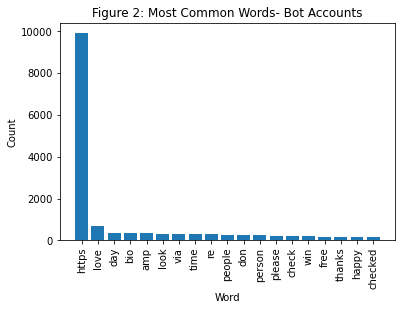

<Figure size 7200x2160 with 0 Axes>

In [35]:
# plot most common words
plt.bar(x = "word", height='count', data=total_bots)
plt.title("Figure 2: Most Common Words- Bot Accounts")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.savefig("bot_word_count")
plt.figure(figsize=(100,30))
plt.show()

In [38]:
# Data Frame of most common words from human accounts
total_human = full_data_human.sum()
total_human = total_human.drop('account_type').sort_values(ascending = False)
total_human = pd.DataFrame(total_human[1:20], columns=['count'])
total_human['word'] = total_human.index
total_human

,count,word
https,33540,https
love,1839,love
amp,1659,amp
time,1517,time
day,1425,day
thank,1424,thank
happy,1367,happy
don,1339,don
re,1334,re
people,1214,people


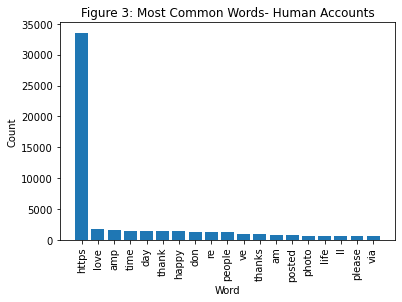

<Figure size 7200x2160 with 0 Axes>

In [39]:
# plot most common words
plt.bar(x = "word", height='count', data=total_human)
plt.title("Figure 3: Most Common Words- Human Accounts")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.savefig("human_word_count")
plt.figure(figsize=(100,30))
plt.show()

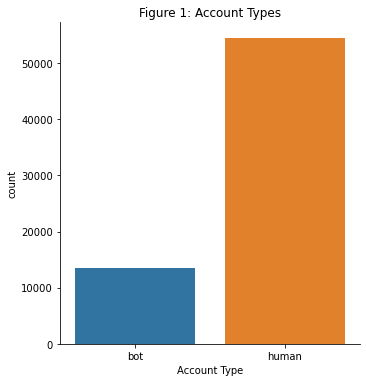

In [40]:
# plot the distribution of the Y variable
sns.catplot(x = "account_type", kind="count", data=full_data)
plt.title("Figure 1: Account Types")
plt.xlabel("Account Type")
plt.savefig("y_distribution", bbox_inches='tight')

In [41]:
# change y to a dummy variable
y = pd.get_dummies(y).drop(columns='human')

In [42]:
# split data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [43]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

# Set preprocess equal to Min Max Scaler to keep our variable distributions
preprocess = pp.MinMaxScaler()

# set sampling to RandomUnderSampler
UnderSample= RandomUnderSampler(random_state=12)

In [44]:
# model fitting- Random Forest
pipe = Pipeline(steps=[('pre_process', preprocess),('sample', UnderSample), ('model',None)])

search_space = [
    
    # Random forest
    {'model' : [RandomForestClassifier(verbose = 3)],
    }
]

# Grid Search to find the best parameters. The metric used for evaluation is balanced accuracy
search = GridSearchCV(pipe, search_space, cv = fold_generator, scoring='accuracy')

# fit the data with the model
search.fit(Xtrain,ytrain)

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 2

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('sample',
                                        RandomUnderSampler(random_state=12)),
                                       ('model', None)]),
             param_grid=[{'model': [RandomForestClassifier(verbose=3)]}],
             scoring='accuracy')

In [45]:
# model fitting- Multinomial Naive Bayes
pipe = Pipeline(steps=[('pre_process', preprocess),('sample', UnderSample), ('model',None)])

search_space = [
    
    # Naive Bayes
    {'model' : [MultinomialNB(alpha = 1)]
    }
]

# Grid Search to find the best parameters. The metric used for evaluation is accuracy
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='accuracy')

# fit the data with the model
search.fit(Xtrain,ytrain)

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expec

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('sample',
                                        RandomUnderSampler(random_state=12)),
                                       ('model', None)]),
             param_grid=[{'model': [MultinomialNB(alpha=1)]}],
             scoring='accuracy')

In [46]:
# extract information to plot ROC curves for multiple models
def get_curve_data(ytrue, yprobs, pos_class_label):
    '''Computes data needed to plot an ROC or precision-recall curve
       Accepts arrays of true values, predicted probabilities, and class label
       Returns a dictionary of arrays for precision, recall, FPR, and TPR scores'''
    precision, recall, thresholds = precision_recall_curve(ytrue, yprobs, pos_label=pos_class_label)
    FPR, TPR, thresholds = roc_curve(ytrue, yprobs, pos_label=pos_class_label)
    rates = pd.DataFrame(dict(fpr=FPR, tpr=TPR))
    return {'precision': precision, 'recall': recall, 'rates': rates}

In [47]:
probabilities = {'Multinomial Naive Bayes': mnb.fit(Xtrain, ytrain.values.ravel()).predict_proba(Xtest), 
                 'Random Forest': RF.fit(Xtrain, ytrain.values.ravel()).predict_proba(Xtest)}
mnb_data = get_curve_data(ytest, probabilities['Multinomial Naive Bayes'][:,1], 1)
RF_data = get_curve_data(ytest, probabilities['Random Forest'][:,1], 1)

NameError: name 'mnb' is not defined

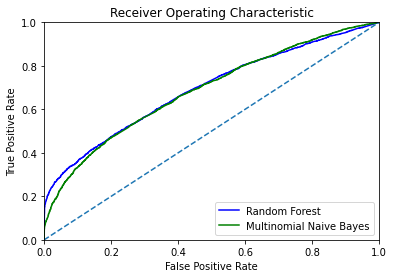

In [141]:
#plot ROC curve
fig_roc = plt.figure()
plt.plot(RF_data['rates'].fpr, RF_data['rates'].tpr, 'blue', label='Random Forest')
plt.plot(mnb_data['rates'].fpr, mnb_data['rates'].tpr, 'green', label='Multinomial Naive Bayes')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


Text(0.5, 1.0, 'RF Confusion Matrix')

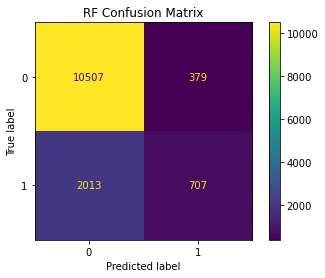

In [191]:
# plot confusion matrix for Random Forest
plot_confusion_matrix(RF, Xtest, ytest)
plt.title('RF Confusion Matrix')

Text(0.5, 1.0, 'MultinomialNB Confusion Matrix')

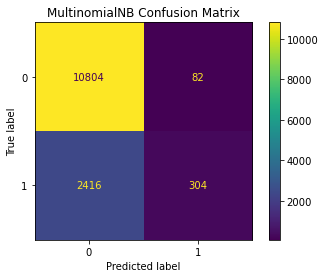

In [192]:
# plot confusion matrix for MNB
plot_confusion_matrix(mnb, Xtest, ytest)
plt.title('MultinomialNB Confusion Matrix')

In [146]:
#Metrics for RF
y_pred = RF.predict(Xtest)
print(balanced_accuracy_score(ytest, y_pred))
print(precision_score(ytest, y_pred))
print(recall_score(ytest, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
0.6296634033459056
0.5162556053811659
0.3386029411764706
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


In [147]:
# Metrics for MNB
y_pred = mnb.predict(Xtest)
print(balanced_accuracy_score(ytest, y_pred))
print(precision_score(ytest, y_pred))
print(recall_score(ytest, y_pred))

0.589947895840313
0.5580969807868252
0.22426470588235295


## TFIDF 

In [157]:
# Create TFIDF DTM 
vect = TfidfVectorizer(stop_words=twitter_stopwords, min_df=20, token_pattern=u'\\b[^\\d\\W]+\\b')
dtm = vect.fit_transform(tweet_bot_or_not['text'])
dtm.shape

(68026, 3078)

In [163]:
# convert vocabulary to dictionary of term indices
vect.vocabulary_
term_indices = {index: term for term, index in vect.vocabulary_.items()}

In [158]:
# create a list of column names from the term indices
colterms = [term_indices[i] for i in range(dtm.shape[1])]

In [159]:
# feature array
X = pd.DataFrame(dtm.toarray(), columns=colterms)

In [160]:
# target array
y = tweet_bot_or_not['account_type']

In [161]:
# change y to a dummy variable
y = pd.get_dummies(y).drop(columns='human')

In [162]:
# split data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [164]:
# model fitting
pipe = Pipeline(steps=[('pre_process', preprocess),('sample', UnderSample), ('model',None)])

search_space = [
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RandomForestClassifier(verbose = 3)],
    }
]

# Grid Search to find the best parameters. The metric used for evaluation is balanced accuracy
search = GridSearchCV(pipe, search_space, cv = fold_generator, scoring='accuracy')

# fit the data with the model
search.fit(Xtrain,ytrain)

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py:281: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 2

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('sample',
                                        RandomUnderSampler(random_state=12)),
                                       ('model', None)]),
             param_grid=[{'model': [RandomForestClassifier(verbose=3)]}],
             scoring='accuracy')

In [165]:
# model fitting
pipe = Pipeline(steps=[('pre_process', preprocess),('sample', UnderSample), ('model',None)])

search_space = [
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [MultinomialNB(alpha = 1)]
    }
]

# Grid Search to find the best parameters. The metric used for evaluation is balanced accuracy
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='accuracy')

# fit the data with the model
search.fit(Xtrain,ytrain)

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expec

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('sample',
                                        RandomUnderSampler(random_state=12)),
                                       ('model', None)]),
             param_grid=[{'model': [MultinomialNB(alpha=1)]}],
             scoring='accuracy')

In [167]:
# model fitting
pipe = Pipeline(steps=[('pre_process', preprocess),('sample', UnderSample), ('model',None)])

search_space = [
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [GaussianNB()]
    }
]

# Grid Search to find the best parameters. The metric used for evaluation is balanced accuracy
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='accuracy')

# fit the data with the model
search.fit(Xtrain,ytrain)

/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expec

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('sample',
                                        RandomUnderSampler(random_state=12)),
                                       ('model', None)]),
             param_grid=[{'model': [GaussianNB()]}], scoring='accuracy')

In [168]:
# extract information to plot ROC curves for multiple models
def get_curve_data(ytrue, yprobs, pos_class_label):
    '''Computes data needed to plot an ROC or precision-recall curve
       Accepts arrays of true values, predicted probabilities, and class label
       Returns a dictionary of arrays for precision, recall, FPR, and TPR scores'''
    precision, recall, thresholds = precision_recall_curve(ytrue, yprobs, pos_label=pos_class_label)
    FPR, TPR, thresholds = roc_curve(ytrue, yprobs, pos_label=pos_class_label)
    rates = pd.DataFrame(dict(fpr=FPR, tpr=TPR))
    return {'precision': precision, 'recall': recall, 'rates': rates}

In [193]:
probabilities = {'Multinomial Naive Bayes': mnb.fit(Xtrain, ytrain.values.ravel()).predict_proba(Xtest), 
                 'Random Forest': RF.fit(Xtrain, ytrain.values.ravel()).predict_proba(Xtest),
                 'Gaussian Naive Bayes': gnb.fit(Xtrain, ytrain.values.ravel()).predict_proba(Xtest)}
mnb_data = get_curve_data(ytest, probabilities['Multinomial Naive Bayes'][:,1], 1)
RF_data = get_curve_data(ytest, probabilities['Random Forest'][:,1], 1)
gnb_data = get_curve_data(ytest, probabilities['Gaussian Naive Bayes'][:,1], 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


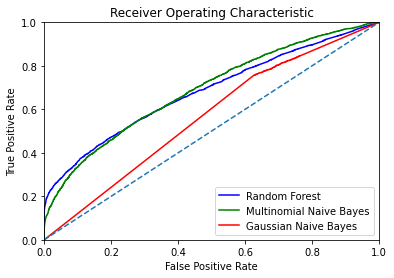

In [195]:
# plot ROC curves
fig_roc = plt.figure()
plt.plot(RF_data['rates'].fpr, RF_data['rates'].tpr, 'blue', label='Random Forest')
plt.plot(mnb_data['rates'].fpr, mnb_data['rates'].tpr, 'green', label='Multinomial Naive Bayes')
plt.plot(gnb_data['rates'].fpr, gnb_data['rates'].tpr, 'red', label='Gaussian Naive Bayes')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


Text(0.5, 1.0, 'RF Confusion Matrix')

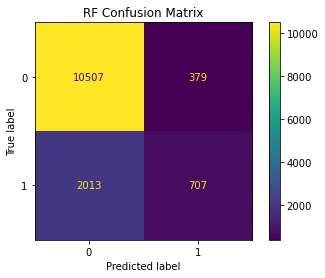

In [190]:
# confusion matrix for RF
plot_confusion_matrix(RF, Xtest, ytest)
plt.title('RF Confusion Matrix')

Text(0.5, 1.0, 'MultinomialNB Confusion Matrix')

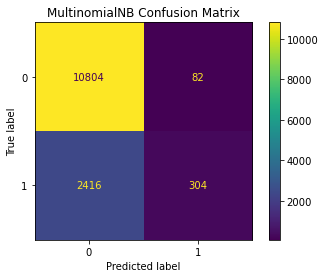

In [196]:
# confusion matrix for mnb
plot_confusion_matrix(mnb, Xtest, ytest)
plt.title("MultinomialNB Confusion Matrix")

Text(0.5, 1.0, 'GaussianNB Confusion Matrix')

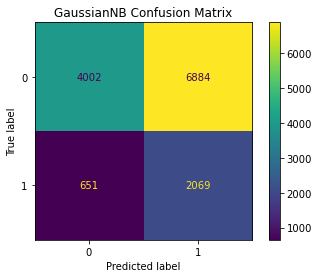

In [189]:
# confusion matrix for gnb
plot_confusion_matrix(gnb, Xtest, ytest)
plt.title("GaussianNB Confusion Matrix")

In [184]:
# MNB metrics
y_pred = mnb.predict(Xtest)
print(balanced_accuracy_score(ytest, y_pred))
print(precision_score(ytest, y_pred))
print(recall_score(ytest, y_pred))

0.5521160475948601
0.7875647668393783
0.11176470588235295


In [188]:
# gnb metrics
y_pred = gnb.predict(Xtest)
print(balanced_accuracy_score(ytest, y_pred))
print(precision_score(ytest, y_pred))
print(recall_score(ytest, y_pred))

0.5641449554743816
0.23109572210432258
0.7606617647058823


In [187]:
# RF metrics
y_pred = RF.predict(Xtest)
print(balanced_accuracy_score(ytest, y_pred))
print(precision_score(ytest, y_pred))
print(recall_score(ytest, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
0.6125555557056555
0.651012891344383
0.2599264705882353
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
